In [16]:
# ==========================================
# DATA PREPROCESSING PIPELINE (UPDATED)
# For: Deep Vision Crowd Monitor Project
# ==========================================

import os
import pandas as pd
from PIL import Image, UnidentifiedImageError
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ------------------------------------------
# 1. Set dataset paths
# ------------------------------------------
# Include both Part A and Part B datasets
dataset_paths = [
    "data/part_A_final/train_data/images",
    "data/part_A_final/test_data/images",
    "data/part_B_final/train_data/images",
    "data/part_B_final/test_data/images"
]

processed_data_dir = "data/processed"
os.makedirs(os.path.join(processed_data_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(processed_data_dir, "test"), exist_ok=True)

# ------------------------------------------
# 2. Define preprocessing transformations
# ------------------------------------------
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Optional augmentation (if you want to apply later)
augment = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ------------------------------------------
# 3. Collect and clean all image paths
# ------------------------------------------
print("Scanning for images...")
all_images = []

for path in dataset_paths:
    if os.path.exists(path):
        for f in os.listdir(path):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                all_images.append(os.path.join(path, f))
    else:
        print(f"Folder not found: {path}")

print(f"Total images found: {len(all_images)}")

print("\nChecking for corrupted images...")
clean_images = []
for img_path in tqdm(all_images):
    try:
        with Image.open(img_path) as img:
            img.verify()  # verify integrity
        clean_images.append(img_path)
    except (UnidentifiedImageError, OSError):
        print(f"Corrupted image skipped: {img_path}")

print(f"Clean images retained: {len(clean_images)}")

# ------------------------------------------
# 4. Train–Test Split
# ------------------------------------------
train_files, test_files = train_test_split(clean_images, test_size=0.2, random_state=42)

print(f"\nTrain files: {len(train_files)}")
print(f"Test files: {len(test_files)}")

# ------------------------------------------
# 5. Apply Preprocessing + Save to new folders
# ------------------------------------------
def process_and_save(files, folder, transform):
    for f in tqdm(files):
        try:
            img = Image.open(f).convert('RGB')
            img_t = transform(img)
            save_path = os.path.join(processed_data_dir, folder, os.path.basename(f))
            img = transforms.ToPILImage()(img_t)
            img.save(save_path)
        except Exception as e:
            print(f"Error processing {f}: {e}")

print("\nProcessing and saving training images...")
process_and_save(train_files, "train", preprocess)

print("Processing and saving test images...")
process_and_save(test_files, "test", preprocess)

# ------------------------------------------
# 6. (Optional) Label Loading
# ------------------------------------------
labels_file = "data/labels.csv"
if os.path.exists(labels_file):
    labels_df = pd.read_csv(labels_file)
    print(f"Loaded labels: {len(labels_df)} records")
else:
    print("No label file found (labels.csv). Skipping label loading for now.")

# ------------------------------------------
# 7. Summary
# ------------------------------------------
print("\nPreprocessing complete!")
print(f"Processed data saved in: {processed_data_dir}")


Scanning for images...
Total images found: 1198

Checking for corrupted images...


100%|██████████| 1198/1198 [00:00<00:00, 4158.51it/s]


Clean images retained: 1198

Train files: 958
Test files: 240

Processing and saving training images...


100%|██████████| 958/958 [00:20<00:00, 46.99it/s]


Processing and saving test images...


100%|██████████| 240/240 [00:04<00:00, 49.53it/s]

No label file found (labels.csv). Skipping label loading for now.

Preprocessing complete!
Processed data saved in: data/processed


In [17]:
import os

def count_images(folder):
    return sum(len(files) for _, _, files in os.walk(folder))

print("Train:", count_images("data/processed/train"))
print("Test:", count_images("data/processed/test"))


Train: 399
Test: 253


In [19]:
def process_and_save(files, folder, transform):
    for f in tqdm(files):
        try:
            img = Image.open(f).convert('RGB')
            img_t = transform(img)
            img = transforms.ToPILImage()(img_t)
            
            # Get the parent folder name (e.g., part_A_train)
            parent = os.path.basename(os.path.dirname(f))
            # Create subfolder inside train/test folder
            save_folder = os.path.join(processed_data_dir, folder, parent)
            os.makedirs(save_folder, exist_ok=True)
            
            save_path = os.path.join(save_folder, os.path.basename(f))
            img.save(save_path)
        except Exception as e:
            print(f"Error processing {f}: {e}")


In [20]:
import os

def count_images(folder):
    return sum(len(files) for _, _, files in os.walk(folder))

print("Train:", count_images("data/processed/train"))
print("Test:", count_images("data/processed/test"))


Train: 399
Test: 253


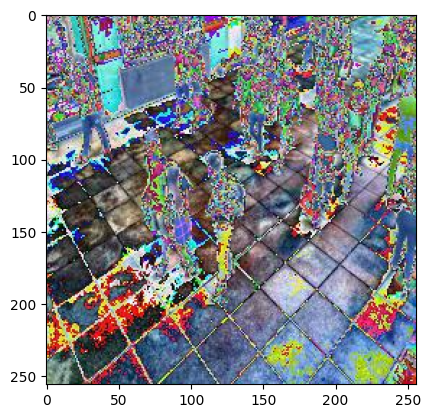

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import os

train_folder = "data/processed/train"
for root, _, files in os.walk(train_folder):
    if files:
        img_path = os.path.join(root, files[0])
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()
        break


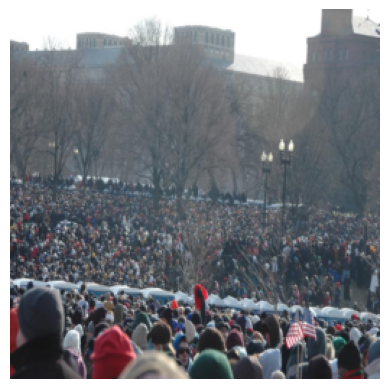

In [8]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

def unnormalize(img_tensor, mean, std):
    img = img_tensor.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return img

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# ---------- CHANGE THIS PATH ----------
img_path = r"data/part_A_final/train_data/images/IMG_299.jpg"
# -------------------------------------

img = Image.open(img_path).convert("RGB")
img_t = transform(img)

img_unnorm = unnormalize(img_t, mean, std)
img_np = img_unnorm.permute(1, 2, 0).numpy()
img_np = img_np.clip(0, 1)

plt.imshow(img_np)
plt.axis("off")
plt.show()


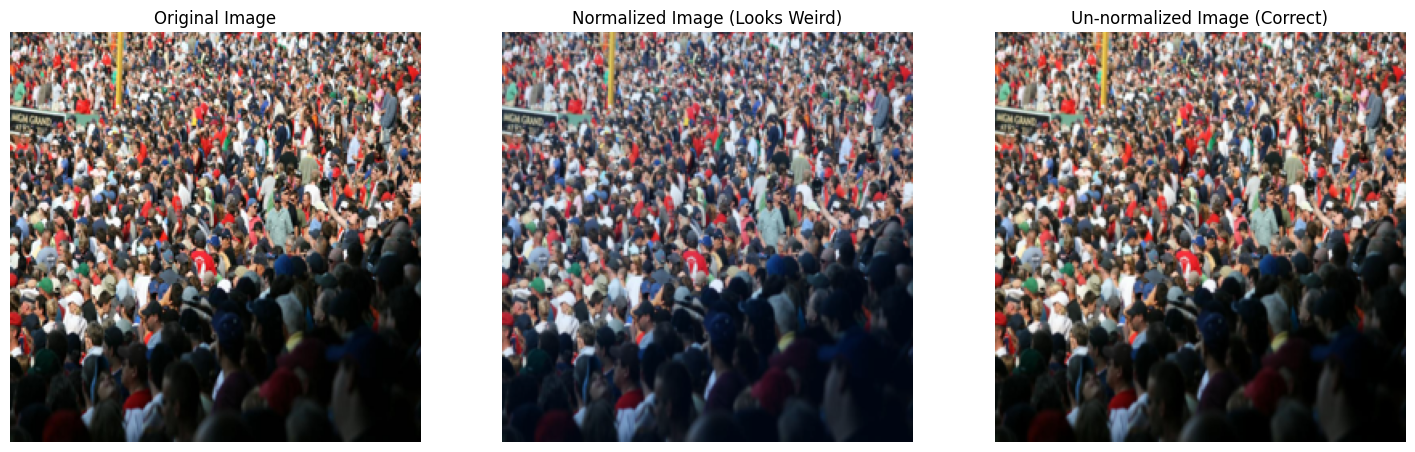

In [5]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# ----------- NORMALIZATION VALUES -----------
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# ----------- UNNORMALIZE FUNCTION -----------
def unnormalize(img_tensor, mean, std):
    img = img_tensor.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return img

# ----------- TRANSFORMS -----------
transform_norm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# ----------- LOAD IMAGE -----------
img_path = r"data/part_A_final/train_data/images/IMG_10.jpg"   # CHANGE THIS
img = Image.open(img_path).convert("RGB")

# ----------- ORIGINAL (RESIZED) -----------
img_resized = img.resize((256, 256))

# ----------- NORMALIZED -----------
img_norm = transform_norm(img)

# Convert for viewing
img_norm_np = img_norm.permute(1, 2, 0).numpy()
img_norm_np = (img_norm_np - img_norm_np.min()) / (img_norm_np.max() - img_norm_np.min())

# ----------- UN-NORMALIZED -----------
img_unnorm = unnormalize(img_norm, mean, std)
img_unnorm_np = img_unnorm.permute(1, 2, 0).numpy().clip(0, 1)

# ----------- DISPLAY ALL THREE -----------
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img_resized)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Normalized Image (Looks Weird)")
plt.imshow(img_norm_np)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Un-normalized Image (Correct)")
plt.imshow(img_unnorm_np)
plt.axis("off")

plt.show()


In [4]:
print("Original:", img_resized)
print("Normalized min:", img_norm.min().item())
print("Normalized max:", img_norm.max().item())


Original: <PIL.Image.Image image mode=RGB size=256x256 at 0x219231C8E50>
Normalized min: -1.7069098949432373
Normalized max: 2.640000104904175
